### Previsão de Ações para o próximo dia

In [1]:
#importando as bibliotecas
import pandas as pd
from pandas import DataFrame
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Instalar Bibliotecas
#!pip install pandas_datareader
#!pip install yfinance --upgrade --no-cache-dir

In [3]:
#importando biblioteca do yahoo finaças
import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()

In [4]:
#Escolher qual ação será feita a previsão

#acao = 'AMAR3.SA' #Marisa
#acao = 'VIIA3.SA' #Via Varejo
#acao = 'TIMS3.SA' #Tim
#acao = 'BRML3.SA' #BR Malls
#acao = 'ITSA4.SA' #Itausa
#acao = 'CIEL3.SA' # Ambev
acao = "CPLE3.SA"

In [5]:
#Obtendo cotações # os numeros devem ser strings - se quiser por data final , end = 'YYYY-MM-DD'
ibov = web.get_data_yahoo(acao, start='2020-11-15')

#salvar arquivo
round(ibov,2).to_csv('acoes.csv')

[*********************100%***********************]  1 of 1 completed


In [6]:
df = pd.read_csv('acoes.csv', index_col = 0)
ontem = df.tail(1)

In [7]:
#Criando uma função para fazer um loop e realizar a previsão dos valores de Máxima, Mínima e Fechamento diário.
def previsa(variavel):
    #criando novos campos de medias móveis
    df = pd.read_csv('acoes.csv', index_col = 0)
    df['mm4d'] = df[variavel].rolling(5).mean()
    #df['mm8d'] = df[variavel].rolling(10).mean()
    
    #separando dados de entrada e saída
    valor_novo = pd.DataFrame(df.iloc[len(df)-1])
    valor = valor_novo.drop(['Open','Adj Close', variavel], 0)
    
    #Empurrando para frente os valores das ações para prever o proximo dia
    df[variavel] = df[variavel].shift(-1)

    #retirando os dados nulos
    df.dropna(inplace=True)
    
    #definindo quantidade de linhas
    qtd_linhas = len(df)
    qtd_linhas_treino= round(.70 * qtd_linhas)
    qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
    qtd_linhas_validacao = qtd_linhas -1

    #separando as features e labels
    features = df.drop(['Open','Adj Close', variavel], 1)
    labels = df[variavel]
    
    #Separa os dados de treino e teste
    X_train = features[:qtd_linhas_treino]
    X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

    y_train = labels[:qtd_linhas_treino]
    y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

    # Normalizando os dados de entrada(features) e gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    #treinamento usando regressão linear
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train)
    pred= lr.predict(X_test_scale)
      
    #Obtendo métricas para o modelo
    EQM = metrics.mean_squared_error(y_test, pred).round(4)
    cd =r2_score(y_test, pred)

    #valor_novo = features.tail(1)
    valor_novo = valor.T
    
    #executando a previsão
    prevs=scaler.transform(valor_novo)

    pr1=float(lr.predict(prevs)) #modelo de REGRESSÃO LINEAR
    
    return round(pr1,2) ,round(cd * 100,2), EQM

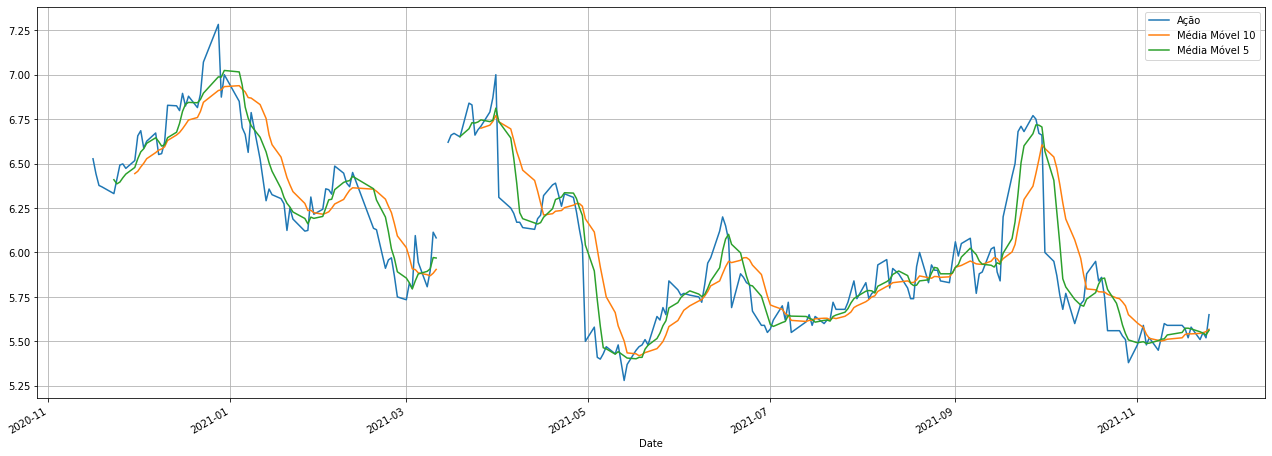

In [8]:
import matplotlib.pyplot as plt
#plotando grafico com amédia móvel
ibov_fatiado = ibov
ibov_fatiado["Close"].plot(figsize=(22,8), label="Ação")
ibov_fatiado["Close"].rolling(10).mean().plot(label="Média Móvel 10")
ibov_fatiado["Close"].rolling(5).mean().plot(label="Média Móvel 5")
plt.grid()
plt.legend();

In [9]:
a = []
a.append(previsa('High'))
a.append(previsa('Low'))
a.append(previsa('Close'))

In [10]:
dados = DataFrame(a, columns = [acao,"R²", "EQM"], index = ['Máxima','Mínima','Fechamento'] ).T
dados

,Máxima,Mínima,Fechamento
CPLE3.SA,5.7000,5.5900,5.6200
R²,89.9400,91.2000,79.8900
EQM,0.0121,0.0102,0.0251
